<a href="https://colab.research.google.com/github/Thehunk1206/Face-Mask-Detector/blob/master/Face_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/My\ Drive/FaceMaskDetector

/content/drive/My Drive/FaceMaskDetector


In [0]:
!tar -xzvf cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

In [0]:
!pip install tensorflow==2.0

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization,\
    Dropout, Dense, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import math  


import os
import numpy as np                                                                                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt

In [4]:
train_dir = "dataset/train"
test_dir = "dataset/test"

num_of_train = 0
num_of_test = 0
for label in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,label)):
        num_of_train+=1

for label in os.listdir(test_dir):
    for i in os.listdir(os.path.join(test_dir,label)):
        num_of_test+=1

print(f"Total training sample:{num_of_train}\n",f"Total test sample:{num_of_test}")

Total training sample:1372
 Total test sample:455


In [0]:
IMG_SIZE = (224,224)
batch_size = 16
epoch = 10

train_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=IMG_SIZE)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE)

Found 1372 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


In [7]:
sample_test_images, labels = next(test_data_gen)
print(labels[0:10])
sample_test_images.shape

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


(16, 224, 224, 3)

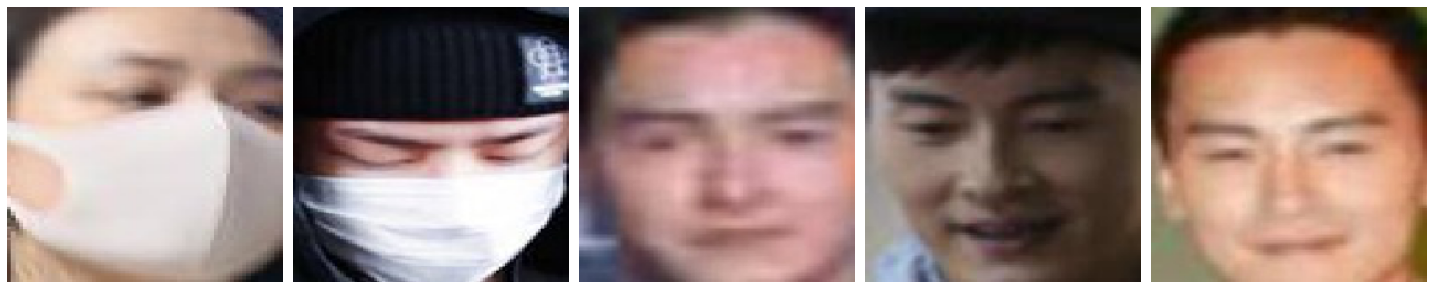

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
def plotImages(images_arr,labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(labels)
    

plotImages(sample_test_images[:5],labels[:5])

In [9]:
head_lyr = MobileNet(input_shape=(224,224,3),weights='imagenet', include_top = False)

x = head_lyr.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2())(x)
x = BatchNormalization()(x)
output = Dense(2,activation='softmax',kernel_regularizer=l2())(x) 

model = Model(inputs=head_lyr.input,outputs = output)

for layer in head_lyr.layers:
  layer.trainable = False

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________________________________

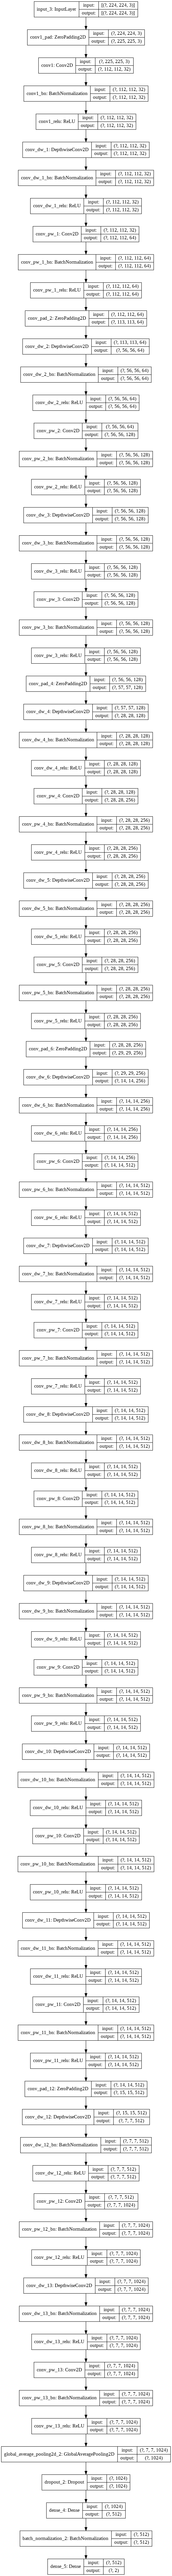

In [25]:
plot_model(model, show_shapes=True, to_file='mobilenet_TL.png')

In [13]:
len(model.layers)

92

In [0]:
def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

opt = Adam(lr=0.001)
lr_sc = LearningRateScheduler(scheduler, verbose=1)


model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy',AUC()])

In [12]:
checkpoint = ModelCheckpoint("mask_net.h5",monitor='val_loss',verbose=1,save_best_only=True)
callback = [lr_sc,checkpoint]

hist = model.fit_generator(generator=train_data_gen,validation_data=test_data_gen,epochs=epoch,callbacks=callback)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 5.5129 - accuracy: 0.9446 - auc_1: 0.9878
Epoch 00001: val_loss improved from inf to 2.72207, saving model to mask_net.h5
86/86 [==============================] - 974s 11s/step - loss: 5.5129 - accuracy: 0.9446 - auc_1: 0.9878 - val_loss: 2.7221 - val_accuracy: 0.9802 - val_auc_1: 0.9960 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 1.9430 - accuracy: 0.9708 - auc_1: 0.9926
Epoch 00002: val_loss improved from 2.72207 to 1.32059, saving model to mask_net.h5
86/86 [==============================] - 63s 735ms/step - loss: 1.9430 - accuracy: 0.9708 - auc_1: 0.9926 - val_loss: 1.3206 - val_accuracy: 0.9868 - val_auc_1: 0.9944 - lr: 0.0010

Epoch 00003: LearningRateScheduler reduc

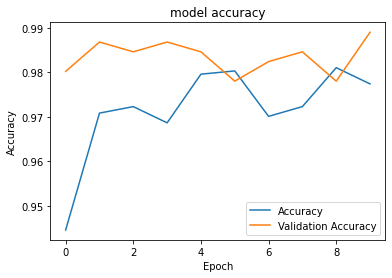

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

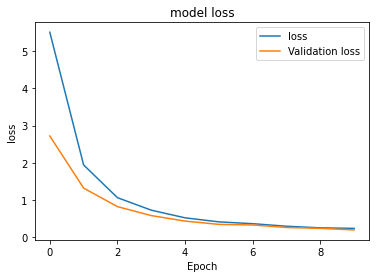

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()